In [1]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra

#need this in memory for the following wrapper, but it only needs to be done once and it takes a while
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)


In [2]:
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom
from calc_del_lambda import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages


def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)

#computer specific directories
dataPath ='/home/agoga/Documents/nreshk/data/'
setName = '22049/'
#22049
#17051
#30495
#49933
#76151
#120136
#190406


obsPath = dataPath + setName+ 'obs/'
flatsPath = dataPath + setName+ 'flats/'

obsDict = dict()
for obFile in os.listdir(obsPath):
    if obFile.endswith(".fits"):
        obsHDu1 = astropy.io.fits.open(obsPath+obFile)
        if(setName.strip('/') not in obsHDu1[0].header['OBJECT']):
            continue
        obsDate = mjd_from_hdu(obsHDu1)
        #print(obFile + ' for mjd: ' + str(obsDate))
        obsDict.update({obsDate:obsHDu1})
        #print(int(obsDate))
        
#print('-------------------------')

flatDict = dict()       
for flFile in os.listdir(flatsPath):
    if flFile.endswith(".fits"):
        flatHDu1 = astropy.io.fits.open(flatsPath+flFile)
        flatDate = mjd_from_hdu(flatHDu1)
        flatDict.update({int(flatDate):flatHDu1})
#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

#resolution for printing
res = .01
label =''

tEffLookup = {"22049":5065,
              "17051":6200,#could not find in references, google's value
              "30495":5834,
              "49933":6674,
              "76151":5761,#could not find in references, google's value
              "120136":6420,#could not find in references, google's value
              "190406":5940
            }

#todo fill this to print out in 
bad = []#[58330.3596906,58330.3634695,
      # 58553.7527935,58553.7479017,
      # 58272.4211262,58272.4248934,
      # 58354.2323109,58354.2381758]

    
#need blank arrays to append to since we don't know length due to bad spectra
data = [[],[],[]]
sites = []
dailyData = dict()
for oK in obsDict:
    fK = closestKey(flatDict,oK)
    
    #checking 
    if abs(oK-fK) > 2:
        print('closest for: '+str(oK) +' is '+ str(abs(oK-fK)))
    oHDu = obsDict[oK]
    fHDu = flatDict[fK]
    
    #read data from files in new format
    waveGrid = oHDu[7].data
    flat = fHDu[0].data
    spec = oHDu[1].data

    #oK Obs key in form of 58330.3596906
    #label for file
    label=str(oK).replace('.','/') 
    #title for pdfs
    title = ''
    
    
    #lookup this star's teff
    tempEff = tEffLookup[setName.strip('/')]
    
    #give multiple arrays of flats whose lam values are stored in multiple wave grid arrays
    flatRet = mk_flatolap(waveGrid, flat)
    #return one flat array with lambda grid
    flatOlap = flatRet[1]
    lamGrid = flatRet[0]

    #get the target data minus the flat
    targOlapf = calc_targOlapf(lamGrid, waveGrid, spec, flatOlap, label)
    
    
    #cross correlation returns a lambda offset(dlam) and save the lab spectra
    correlation = tmp_find_del_lam(lab[0]/10,lab[1], lamGrid, targOlapf,res)
    dLam = correlation[0]
    labSpec = correlation[2]
    
    
    #TODO
    #bad_spec_detection(lamGrid-dLam, targOlapf)
    
    #radial velocity calculation
    lamRef = 396.85
    #delta lamda / ref lamda * speed of light
    rv = dLam/ lamRef * sc.c 
    #rv from meters to km/s as desired by hk_windows
    #atm we're not going to apply the radial velocity and just use the adjusted spectra
    rv = 0#rv/10000 

    
    
    
    #find SHK with new offset to lamda grid
    shkRet = calc_shk(lamGrid-dLam, targOlapf, rv, teff=tempEff)
    shk = shkRet[0]
    windows = shkRet[1]
    print('MJD: ' + str(oK) + ' w/ shk: ' + str(shk) + ' and offset:' + str(dLam))
    
    
    badSpec = bad_spec_detection(lamGrid-dLam, targOlapf)
    if shk < 0:
        badSpec = True
        
    
    if badSpec:
        bad.append(oK)
        title +='BAD '
    
    #create the directories for pdf plotting and save every intermediate data array
    first = label.split("/")[0]
    second = label.split("/")[1]
    mkdir_p("output/"+setName+first+'/')
    np.savez("output/"+setName+first+"/"+ second+"_data", targOlapf=targOlapf,flatOlap=flatOlap, lamGrid=lamGrid, adjLamGrid=lamGrid-dLam,windows=windows)

    site = obsDict[oK][0].header['SITEID']
        
    
    title += 'NRES spectra, ' + site +', '+obsDict[oK][0].header['DATE-OBS']+' ('+ obsDict[oK][0].header['DATE']+'), S='+str(shk)
    
    pdf_from_data(lamGrid, labSpec,lamGrid-dLam, targOlapf, windows,title, "output/"+setName+first+"/",second,flatOlap,.3)
    
    
    
    
        #among other things?!
        
    if(badSpec):
        print('bad: ' + str(mjd_from_hdu(obsDict[oK])))
        continue
            
    dailyData.update({oK:tuple((lamGrid,correlation[0],targOlapf,shk))})        
    data[0].append(mjd_from_hdu(obsDict[oK]))
    data[1].append(shk)
    #sites.append(tuple((site,False)))
    data[2].append(tuple((site,False)))
    

    
#output of this wrapper is an array of data, MJD vs SHK,
#and an equivelant length array with strings correlating to the site

MJD: 58471.952604 w/ shk: 0.49042761704728166 and offset:0.19691407923998508
MJD: 58471.9574956 w/ shk: 0.48806191247547953 and offset:0.2376353122555206
MJD: 58497.8457527 w/ shk: 0.5083781564589939 and offset:0.16471130103025236
bad: 58497.8457527
MJD: 58497.8506448 w/ shk: 0.5088103881644107 and offset:0.1802869571173674
bad: 58497.8506448
MJD: 58538.7946656 w/ shk: 0.45816386139559895 and offset:0.21837169534244308
MJD: 58538.799557 w/ shk: 0.45860343718839175 and offset:0.18191791344872593
MJD: 58655.1802291 w/ shk: 0.42863725203935293 and offset:0.1020106988833538
bad: 58655.1802291
MJD: 58655.1851092 w/ shk: 0.3992154453174323 and offset:0.09038755006462264
closest for: 58372.9628576 is 10.96285760000319
MJD: 58372.9628576 w/ shk: 0.5069364615117531 and offset:0.13672958534062402
closest for: 58372.9677498 is 10.967749800001911
MJD: 58372.9677498 w/ shk: 0.4877406027137567 and offset:0.16806806347818223
MJD: 58394.9053518 w/ shk: 0.4975371187564126 and offset:0.17796721543508726

In [3]:
from scipy import interpolate

done = []
for curD in dailyData:
    #dont double up
    if(curD in done):
        continue
    #find the closest MJD to the current
    same = min(dailyData, key=lambda x:abs(x-curD) if x!=curD else 10000)
    
    
    #print(str(curD) + ' and ' + str(same) + ' with diff ' + str(curD - same)) 
    #if these obs are more than a day apart this is not what we want
    if abs(curD - same) >= 1:
        #print(curD - same)
        continue
        
    #print('got here')
    #create an array of all the spectra that have been done, i..e these two are now done
    done.append(curD)
    done.append(same)
    
    

    #grab the values
    tmp = dailyData[curD]
    curLamGrid=tmp[0]
    curTargOlapf=tmp[2]
    curDLam=tmp[1]
    
    sameD = dailyData[same]
    sameLamGrid=sameD[0]
    sameTargOlapf=sameD[2]
    sameDLam=sameD[1]
    

    first = str(curD).split('.')[0]

    #The issue is the two targetOlaps are on different grids. Interp them on the same grid then add
    interpfunc = interpolate.interp1d(curLamGrid-curDLam, curTargOlapf, kind='linear',fill_value='extrapolate')
    curTarg=interpfunc(lamGrid)
    
    interpfunc = interpolate.interp1d(sameLamGrid-sameDLam, sameTargOlapf, kind='linear',fill_value='extrapolate')
    sameTarg=interpfunc(lamGrid)
    
    
    combinedTarg = curTarg+sameTarg
    
    #lookup this star's teff
    tempEff = tEffLookup[setName.strip('/')]
    
    #find SHK with new offset to lamda grid
    shkRet = calc_shk(lamGrid, combinedTarg, rv, teff=tempEff)
    
    shk = shkRet[0]
    windows = shkRet[1]
    
    
    mkdir_p("output/"+setName+first+'/')
    np.savez("output/"+setName+first+"/combined_data", targOlapf=combinedTarg,flatOlap=combinedTarg, lamGrid=lamGrid, adjLamGrid=lamGrid,windows=windows)

    site = obsDict[curD][0].header['SITEID']
    title = 'NRES spectra, ' + site +', '+obsDict[curD][0].header['DATE-OBS']+' ('+ obsDict[oK][0].header['DATE']+'), S='+str(shk)
    pdf_from_data(lamGrid, labSpec,lamGrid, combinedTarg,windows,title, "output/"+setName+first+"/","combined",width=.3)
    
    
    
    data[0].append(curD)
    data[1].append(shk)
    data[2].append(tuple((site,True)))
    #sites.append(tuple((site,True)))
    
#for i in oldData[0]:
#    data[0].append(i)
#for i in oldData[1]:
#    data[1].append(i)
#for i in oldSites:
#    sites.append(i)   


0.0009999999999763531


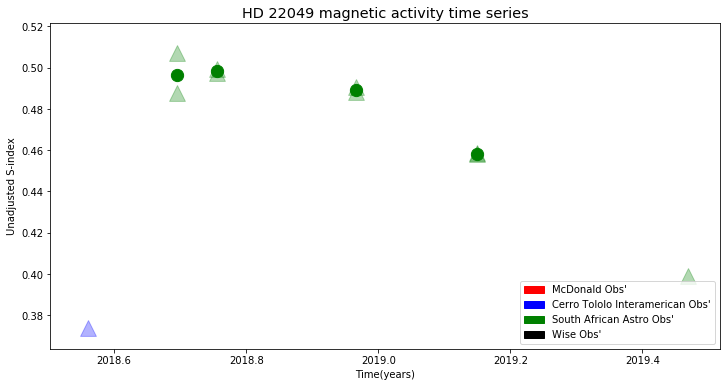

In [4]:
print(lamGrid[1]-lamGrid[0])
from astropy.time import Time

import matplotlib.patches as mpatches


mjdArray = np.asarray(data[0])
shkValArray = np.asarray(data[1])
siteArray = np.asarray(data[2])


fig, ax = plt.subplots(figsize=(12,6))

pltStr = []
for s in siteArray:
    tStr =''
    if s[0] == 'lsc':
        tStr +='b'
    elif s[0] == 'cpt':
        tStr +='g'
    elif s[0]== 'elp':
        tStr +='r'
    elif s[0]=='tlv':
        tStr +='k'
        
    if s[1] == 'True':
        tStr += 'o'
    else:
        tStr += '^'   
    pltStr.append(tStr)
    
    
t= Time(mjdArray, format='mjd')
t.format = 'decimalyear'


for i in range(len(pltStr)):
    mark = pltStr[i][1]
    col = pltStr[i][0]
    size = 250
    opac = .3
    if mark == 'o':
        size = 150
        opac = 1
        
    if mjdArray[i] not in bad:    
        plt.scatter(t[i].value,shkValArray[i],marker=mark,c=col, s=size, alpha = opac)

rl = mpatches.Patch(color='red', label='McDonald Obs\'')
bl = mpatches.Patch(color='blue', label='Cerro Tololo Interamerican Obs\'')
gl = mpatches.Patch(color='green', label='South African Astro Obs\'')
kl = mpatches.Patch(color='black', label='Wise Obs\'')
#sLeg = mpatches.Patch(color='blue', label='combined s val')
plt.legend(handles=[rl,bl,gl,kl],prop={'size': 10}, loc=4)

plt.style.use('classic')
#plt.rcParams['axes.titlesize'] = 22
ax.ticklabel_format(useOffset=False)
plt.title('HD '+setName.strip('/')+' magnetic activity time series')
plt.xlabel('Time(years)')
plt.ylabel('Unadjusted S-index')
plt.savefig('output/'+setName+setName.strip('/')+'_shk_time_series.pdf')
plt.show()
plt.close()

NameError: name 'tmpArray' is not defined